In [ ]:
#!pip install scikit-learn --upgrade
#!pip install tensorflow --upgrade
#!pip install scikeras

!pip install scikit-learn==1.3.0
!pip install tensorflow==2.13.0
!pip install scikeras==0.10.1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 1.0683 - val_loss: 0.7937
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.7687 - val_loss: 0.6604
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.6499 - val_loss: 0.5367
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.5383 - val_loss: 0.4431
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4266 - val_loss: 0.3667
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.3721 - val_loss: 0.3071
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.3036 - val_loss: 0.2570
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.2594 - val_loss: 0.2186
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.2242 - val_loss: 0.1921
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1953 - val_loss: 0.1665
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1784 - val_loss: 0.1476
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/s

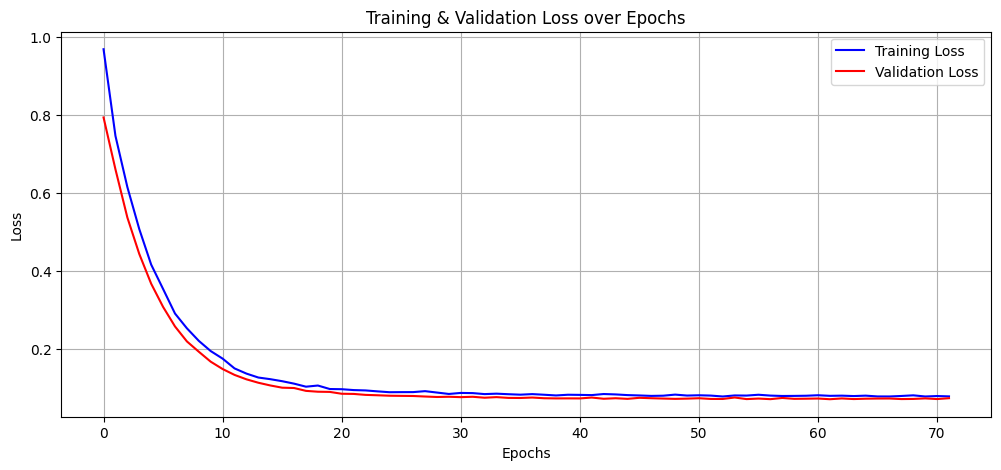

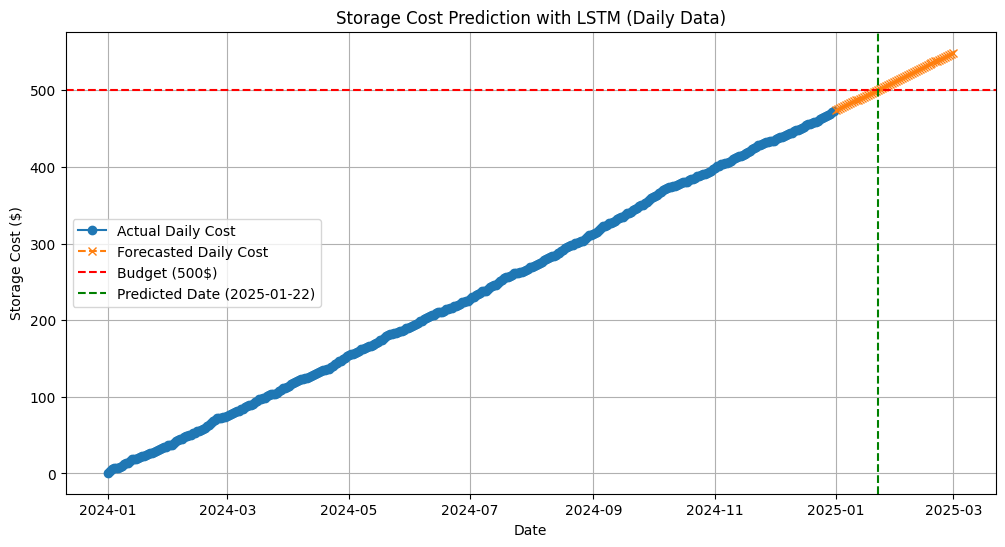

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# 데이터 생성 및 초기 설정
storage_cost = 0.025
budget = 500  # 목표 예산
forecast_steps = 60  # 예측할 최대 일 수

# 샘플 date
year = 2024
start_date = f"{year}-01-01"
end_date = f"{year}-12-31"
dates = pd.date_range(start=start_date, end=end_date)

# 하루당 증가 용량 (GB)
np.random.seed(42)

storage = pd.DataFrame({
    'Daily_using': np.random.uniform(5, 100, size=len(dates))
})

storage['Date'] = dates
storage['Daily_growth'] = storage['Daily_using'].cumsum()
storage['Daily_cost'] = storage['Daily_growth'] * storage_cost
storage.set_index('Date', inplace=True)

# 데이터 준비
data = pd.DataFrame({
    'TotalCost': storage['Daily_cost']
})

data['Diff'] = data['TotalCost'].diff().fillna(0)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Diff']])

# LSTM 입력 데이터 준비 함수
def create_lstm_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 90
X, y = create_lstm_dataset(data_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # LSTM 입력 형식

# LSTM 모델 구성
model = Sequential()
model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(look_back, 1)))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=1e-4, verbose=1)

# 모델 학습 (검증 데이터 추가)
history = model.fit(X, y, epochs=100, batch_size=16, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# 예측 데이터 생성
X_forecast = data_scaled[-look_back:]
X_forecast = np.reshape(X_forecast, (1, look_back, 1))

forecast_scaled = []
for _ in range(forecast_steps):
    next_step = model.predict(X_forecast, verbose=0)
    forecast_scaled.append(next_step[0, 0])
    X_forecast = np.append(X_forecast[:, 1:, :], next_step.reshape(1, 1, 1), axis=1)

# 차분 데이터 복원
forecast_diff = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast_cumulative = [data['TotalCost'].iloc[-1]] + list(np.cumsum(forecast_diff) + data['TotalCost'].iloc[-1])

# 예산 도달 시점 계산
predicted_day = None
for i, cost in enumerate(forecast_cumulative[1:], start=1):
    if cost >= budget:
        predicted_day = i
        break

if predicted_day:
    predicted_date = data.index[-1] + pd.Timedelta(days=predicted_day)
    print(f"예산 {budget}$는 약 {predicted_day}일 후에 도달할 것으로 예측됩니다.")
    print(f"해당 날짜는 {predicted_date.strftime('%Y-%m-%d')}입니다.")
else:
    print(f"{forecast_steps}일 내에 예산 {budget}$에 도달하지 않을 것으로 예측됩니다.")

# 예측 정확도 계산
y_true = data['TotalCost'][-forecast_steps:]
y_pred = forecast_cumulative[1:len(y_true) + 1]
if len(y_true) > 0:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
else:
    print("예측 정확도를 계산할 충분한 데이터가 없습니다.")

# 학습 과정 시각화 (Loss 그래프)
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['TotalCost'], label='Actual Daily Cost', marker='o')
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
plt.plot(future_dates, forecast_cumulative[1:], label='Forecasted Daily Cost', marker='x', linestyle='--')
plt.axhline(y=budget, color='r', linestyle='--', label=f'Budget ({budget}$)')
if predicted_day:
    plt.axvline(x=predicted_date, color='g', linestyle='--', label=f'Predicted Date ({predicted_date.strftime("%Y-%m-%d")})')
plt.xlabel('Date')
plt.ylabel('Storage Cost ($)')
plt.title('Storage Cost Prediction with LSTM (Daily Data)')
plt.legend()
plt.grid()
plt.show()
